<a href="https://colab.research.google.com/github/elenipapadopoulou4/thesis-code/blob/main/ValenceArousal_Estimation_AffectNet_data_augmentation_CC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Train RESNET network on AffectNet dataset for Valence & Arousal 

Τα valence και arousal είναι συνεχείς και λαμβάνουν τιμές απο [-1,1]  <br>


valence -- > δείχνει πόσο θετικό/αρνητικό είναι το συναίσθημα που απεικονίζεται

arousal -- > δείχνει πόσο ενεργητική/παθητική είναι η συναισθηματική κατάσταση

In [ ]:
import tensorflow as tf

import os 
import matplotlib.pyplot as plt

import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,GlobalAveragePooling2D,Dropout


from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint 

import matplotlib.image as mpimg

from keras.models import model_from_json
import json

from keras import backend as K

import pandas as pd

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
from scipy.stats import pearsonr
from tabulate import tabulate

import statistics

import joblib

import scipy

import pickle


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!tar -xvf  '/content/gdrive/MyDrive/train_net/datasets/affectnet_new/train_set.tar' -C '/content'

In [ ]:
!rm -r /content/train_set/annotations/

In [ ]:
!tar -xvf  '/content/gdrive/MyDrive/train_net/datasets/affectnet_new/val_set.tar' -C '/content'

In [ ]:
# folder path
dir_path = "/content/train_set/images"
count = 0
# Iterate directory
for path in os.listdir(dir_path):
    count += 1
print('File count:', count)

In [ ]:
# folder path
dir_path = "/content/val_set/images"
count = 0
# Iterate directory
for path in os.listdir(dir_path):
    count += 1
print('File count:', count)

In [ ]:
dataset_train_path = '/content/train_set/images'
dataset_val_path = '/content/val_set/images'


## create dataframe

In [ ]:
#read dataframe from csv

df_train = pd.read_csv('/content/gdrive/MyDrive/train_net/datasets/affectnet/train_dataframe_final.csv') 
df_val = pd.read_csv('/content/gdrive/MyDrive/train_net/datasets/affectnet/val_dataframe_final.csv') 

df_train = df_train.drop(["expression"],axis=1)
df_val = df_val.drop(["expression"],axis=1)

In [ ]:
df_train

,face_name_align,valence,arousal,race,gender,age
0,/content/train_set/images/102819.jpg,-0.404762,0.476190,Indian,Male,30-39
1,/content/train_set/images/364716.jpg,0.754936,0.101626,White,Female,10-19
2,/content/train_set/images/50848.jpg,0.714286,-0.174603,White,Female,20-29
3,/content/train_set/images/228471.jpg,-0.425861,0.445219,Asian,Male,20-29
4,/content/train_set/images/324085.jpg,-0.029036,0.701703,White,Female,20-29
...,...,...,...,...,...,...
286589,/content/train_set/images/329316.jpg,0.285714,-0.500000,White,Male,20-29
286590,/content/train_set/images/44921.jpg,0.004839,0.004839,White,Female,20-29
286591,/content/train_set/images/21475.jpg,0.334889,0.803733,White,Female,3-9
286592,/content/train_set/images/290369.jpg,-0.125823,0.783972,White,Male,50-59


In [ ]:
df_val

,face_name_align,valence,arousal,race,gender,age
0,/content/val_set/images/5158.jpg,-0.542092,0.637755,Black,Male,20-29
1,/content/val_set/images/5166.jpg,-0.650794,0.634921,White,Female,60-69
2,/content/val_set/images/5162.jpg,-0.663717,0.674252,Indian,Male,20-29
3,/content/val_set/images/5156.jpg,-0.714286,0.484127,White,Male,30-39
4,/content/val_set/images/5157.jpg,-0.750605,0.423729,White,Male,50-59
...,...,...,...,...,...,...
3981,/content/val_set/images/374.jpg,-0.634921,0.626984,White,Female,20-29
3982,/content/val_set/images/364.jpg,-0.056073,0.901484,Black,Male,0-2
3983,/content/val_set/images/373.jpg,-0.721660,0.505689,White,Female,30-39
3984,/content/val_set/images/371.jpg,-0.591463,0.619148,White,Female,20-29


# Before Split

##Show data

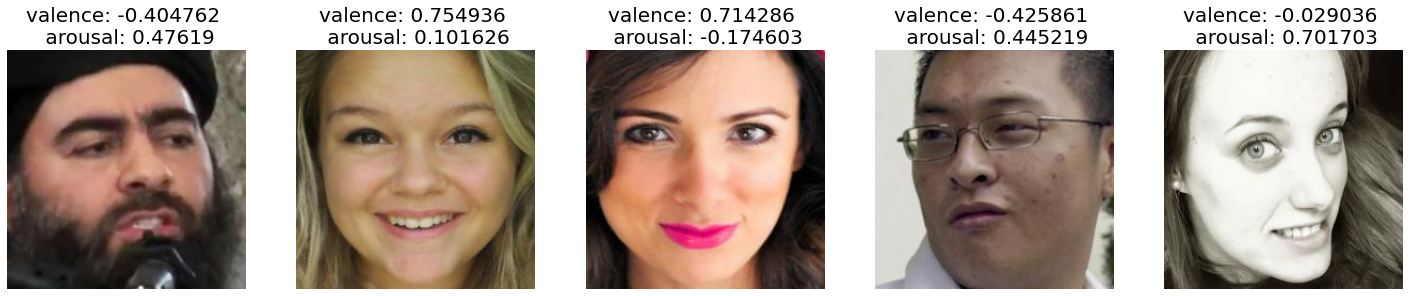

In [ ]:
num_images = 5
fig, axs = plt.subplots(figsize=(20, 4), ncols=num_images, constrained_layout=True)
for i in range(num_images):
  image  =  mpimg.imread(df_train['face_name_align'][i])
  axs[i].imshow(image)  
  axs[i].set_title('valence: {} \n arousal: {}'.format(df_train['valence'][i],df_train['arousal'][i]),fontsize = 20)
  axs[i].axis("off")



## data preprocessing 

In [ ]:
# load one image
image = Image.open(df_train['face_name_align'][30])
# convert image to numpy array
data = np.asarray(image)

In [ ]:
print(np.shape(data))

(224, 224, 3)


Οι εικόνες που στέλνουμε στο νευρωνικό δίκτυο είναι resized σε 224*224και είναι έγχρωμες (τιμές απο 0-255). <br>

  Έτσι στο δίκτυο οι πίνακες είναι μεγέθους 224 * 224 * 3. <br>Μειώνω τις διαστάσεις των εικόνων σε 112 * 112 * 3 

In [ ]:
# get batches of tensor image data (rescaled to 0-1)
train_datagen = ImageDataGenerator(rescale=1./255,horizontal_flip=True,brightness_range=[0.2,1.0])
test_datagen = ImageDataGenerator(rescale=1./255,horizontal_flip=True,brightness_range=[0.2,1.0])

In [ ]:
batch_size = 128 #larger batch size for concordance coeff
#load and iterate training dataset
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='face_name_align',
    y_col=['valence','arousal'], #multitask
    target_size=(112, 112), 
    color_mode='rgb',
    class_mode='raw', #regression
    batch_size=batch_size
)
# load and iterate validation dataset
validation_generator = test_datagen.flow_from_dataframe(
    df_val,
    x_col='face_name_align',
    y_col=['valence','arousal'],
    target_size=(112, 112), 
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size
)

Found 286594 validated image filenames.
Found 3986 validated image filenames.


## data distribution

In [ ]:
def show_v_a_distribution(df_train,df_val):
 
  sets = ['train','validation']
  fig,axs = plt.subplots(figsize =(15, 5),ncols=2)
  for i,df in enumerate([df_train,df_val]):
    x = df['arousal']
    y = df['valence']
    hist = axs[i].hist2d(x, y,range =  [[-1, 1], [-1, 1]])
    axs[i].set_xlabel('arousal', fontsize=12)
    axs[i].set_ylabel('valence', fontsize=12)
    axs[i].set_title("Distribution of {} set".format(sets[i]), fontsize=15)
    fig.colorbar(hist[3], ax=axs[i])


In [ ]:
def plot_samples(category_name,names,counter_train,counter_val):
  f, axs = plt.subplots(2,2,figsize=(16,5))
  plt.subplot(1, 2, 1) # row 1, col 2 index 1
  plt.bar(names,counter_train,color='c',  edgecolor='black')
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.title("{} for train set".format(category_name),fontsize=15)

  plt.subplot(1, 2, 2) # row 1, col 2 index 1
  plt.bar(names,counter_val,color='c',  edgecolor='black')
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.title("{} for validation set".format(category_name),fontsize=15)
  plt.show()


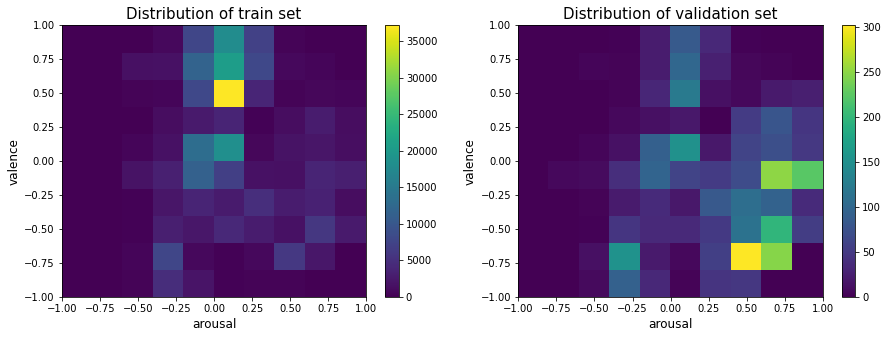

In [ ]:
show_v_a_distribution(df_train,df_val)

Απο τα παραπάνω παρατηρώ πως τα σύνολα δεδομένων αποτελούνται απο εικόνες οι οποίες έχουν τις διαφορετικές κατανομές για τις τιμές valence και arousal

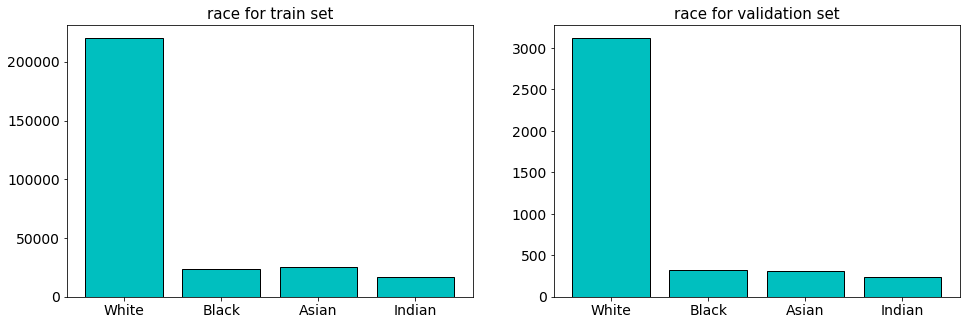

In [ ]:
race_names = ['White','Black','Asian','Indian']

race_counter_train = []
for i in range(len(race_names)):
  race_counter_train.append(len(df_train[df_train['race']==race_names[i]]))

race_counter_val = []
for i in range(len(race_names)):
  race_counter_val.append(len(df_val[df_val['race']==race_names[i]]))

plot_samples('race',race_names,race_counter_train,race_counter_val)


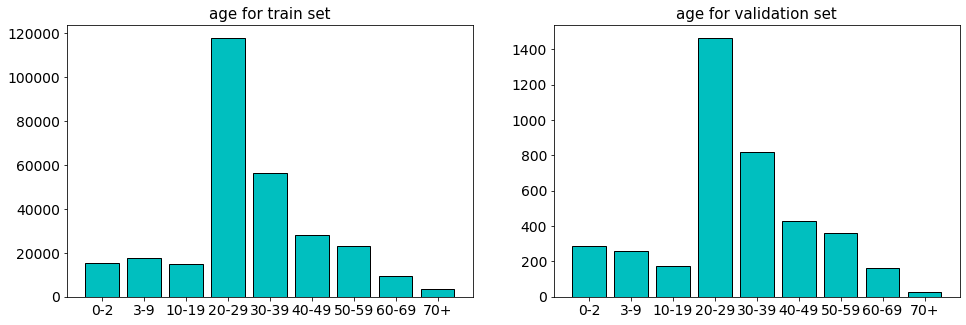

In [ ]:
age_names = ['0-2','3-9','10-19','20-29','30-39','40-49','50-59','60-69','70+']

age_counter_train = []
for i in range(len(age_names)):
  age_counter_train.append(len(df_train[df_train['age']==age_names[i]]))

age_counter_val = []
for i in range(len(age_names)):
  age_counter_val.append(len(df_val[df_val['age']==age_names[i]]))

plot_samples('age',age_names,age_counter_train,age_counter_val)


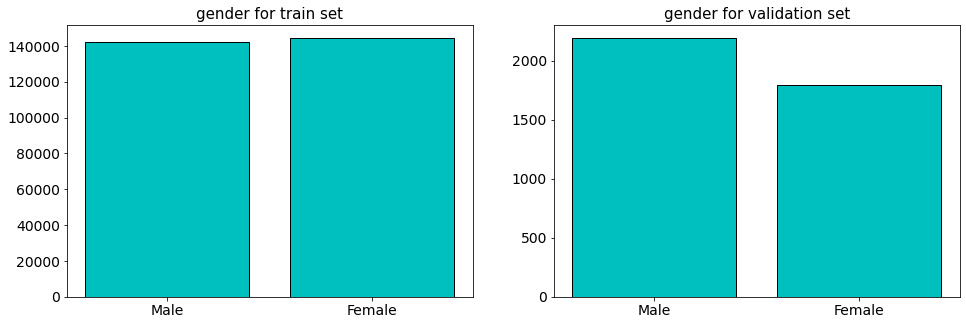

In [ ]:
gender_names = ['Male','Female']

gender_counter_train = []
for i in range(len(gender_names)):
  gender_counter_train.append(len(df_train[df_train['gender']==gender_names[i]]))

gender_counter_val = []
for i in range(len(gender_names)):
  gender_counter_val.append(len(df_val[df_val['gender']==gender_names[i]]))
plot_samples('gender',gender_names,gender_counter_train,gender_counter_val)


## training

In [ ]:
#Metric: Pearsons Correlation Coefficient
def pearson_r(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    r_num = K.sum(xm * ym)
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = K.sqrt(x_square_sum * y_square_sum) + K.epsilon()
    r = r_num / r_den
    return K.mean(r)

In [ ]:
#correlation coef loss function
def concordance_cc2(predictions,labels):
    pred_mean, pred_var = tf.nn.moments(predictions, (0,))
    gt_mean, gt_var = tf.nn.moments(labels, (0,))

    mean_cent_prod = tf.reduce_mean((predictions - pred_mean) * (labels - gt_mean))

    return 1 - (2 * mean_cent_prod) / (pred_var + gt_var + tf.square(pred_mean - gt_mean))




In [ ]:
def concordance_cc2_loss(labels,predictions):
  #split valence and arousal values
  labels_valence = labels[:,0]  
  predictions_valence = predictions[:,0]

  
  labels_arousal = labels[:,1]
  predictions_arousal = predictions[:,1]

  return ( concordance_cc2(predictions_valence, labels_valence) + concordance_cc2(predictions_arousal, labels_arousal) ) / 2 



In [ ]:
#pretrained model 
base_model =  tf.keras.applications.ResNet50(
    include_top=False, #custume input and output layers based on our data
    weights="imagenet", #use weights from imagenet training 
    input_shape=(112,112,3),
    pooling='avg',
)

#use functional API to allow multiple outputs
# input shape
inputs = tf.keras.Input(shape=(112, 112, 3))
# model architecture
x = base_model(inputs, training=True)
x = Dense(512, activation="relu")(x)

#output --> 2 tasks: valence & arousal
outputs = tf.keras.layers.Dense(2,activation="linear")(x) #change to tanh and see results
model = tf.keras.Model(inputs, outputs)
  

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 24,637,826
Trainable params: 24,584,706
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
#compile model
model.compile(optimizer=Adam(learning_rate=0.001),
                     loss= concordance_cc2_loss) #mean absolute error, Pearsons Correlation Coefficient

In [ ]:
#checkpoint 
filepath = "/content/gdrive/MyDrive/train_net/ckp_models/AffectNetVA/AffectNetVA_aug/AffectNetVA_before_128/AffectNet-{epoch:02d}.h5"
checkpoint = ModelCheckpoint(  
    filepath,
    monitor="val_loss",
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch")

callbacks_list = [checkpoint]


#fit model
history = model.fit(train_generator,validation_data=validation_generator,epochs=10,callbacks=callbacks_list)


Epoch 1/10
2240/2240 [==============================] - ETA: 0s - loss: 0.3663
Epoch 1: saving model to /content/gdrive/MyDrive/train_net/ckp_models/AffectNetVA/AffectNetVA_aug/AffectNetVA_before_128/AffectNet-01.h5
2240/2240 [==============================] - 929s 406ms/step - loss: 0.3663 - val_loss: 0.6255
Epoch 2/10
2240/2240 [==============================] - ETA: 0s - loss: 0.3141
Epoch 2: saving model to /content/gdrive/MyDrive/train_net/ckp_models/AffectNetVA/AffectNetVA_aug/AffectNetVA_before_128/AffectNet-02.h5
2240/2240 [==============================] - 871s 389ms/step - loss: 0.3141 - val_loss: 0.5724
Epoch 3/10
2240/2240 [==============================] - ETA: 0s - loss: 0.2991
Epoch 3: saving model to /content/gdrive/MyDrive/train_net/ckp_models/AffectNetVA/AffectNetVA_aug/AffectNetVA_before_128/AffectNet-03.h5
2240/2240 [==============================] - 863s 385ms/step - loss: 0.2991 - val_loss: 0.5411
Epoch 4/10
2240/2240 [==============================] - ETA: 0s - l

## evaluation


In [ ]:
RACES =['White','Black','Asian','Indian']
AGES = ['0-2','3-9','10-19','20-29','30-39','40-49','50-59','60-69','70+']
GENDERS = ['Male','Female']

In [ ]:
batch_size = 128
#create a test generator with no shuffle
test_generator = test_datagen.flow_from_dataframe(
    df_val,
    x_col='face_name_align',
    y_col=['valence','arousal'],
    target_size=(112, 112),
    color_mode='rgb',
    class_mode='raw', #multilabel output
    batch_size=batch_size,
    shuffle = False
  )


Found 3986 validated image filenames.


In [ ]:
#new correlation coef
def concordance_cc2_eval(r1, r2): #r1,r2 = labels,predictions
     mean_cent_prod = np.mean((r1 - np.mean(r1)) * (r2 - np.mean(r2)))
     return (2 * mean_cent_prod) / (np.var(r1) + np.var(r2) + (np.mean(r1) - np.mean(r2)) ** 2)


In [ ]:
def correlation_mse_mae(labels,predictions):
  correlation = concordance_cc2_eval(labels, predictions)
  mse = mean_squared_error(labels, predictions)
  mae = mean_absolute_error(labels, predictions)
  return (correlation,mse,mae)




In [ ]:
def predictions_labels_category(test_generator,df_test,labels,predictions,category_list,category_name):
  y_pred = {key: [] for key in category_list}
  y_true = {key: [] for key in category_list}
  category_counter = {key: [] for key in category_list} # values are list of indexes of each category

  for i,name in enumerate(test_generator.filenames): 
    category_filename = df_test.loc[df_test['face_name_align'] == name, category_name].item()
    for cat in category_list:
      if category_filename == cat:
        category_counter[cat].append(i)
        y_pred[cat].append(predictions[i])
        y_true[cat].append(labels[i])
    
  return y_true,y_pred,category_counter

In [ ]:
models_labels = {}
models_predictions = {}
models_directory = '/content/gdrive/MyDrive/train_net/ckp_models/AffectNetVA/AffectNetVA_aug/AffectNetVA_before_128'
for saved_model in (os.listdir(models_directory)):
  model = tf.keras.models.load_model(os.path.join(models_directory,saved_model),custom_objects={'concordance_cc2_loss':concordance_cc2_loss})
  models_labels[saved_model[:-3]] = test_generator.labels
  models_predictions[saved_model[:-3]] = model.predict(test_generator)


In [ ]:
def valence_arousal(labels,predictions):
  valence_labels= []
  valence_predictions = []
  arousal_labels = []
  arousal_predictions = []

  for (v_l,a_l),(v_p,a_p) in zip(labels,predictions):
    valence_labels.append(v_l)
    valence_predictions.append(v_p)
    arousal_labels.append(a_l)
    arousal_predictions.append(a_p)

  return valence_labels,valence_predictions,arousal_labels,arousal_predictions

In [ ]:
for model_name in models_labels.keys():
  
  valence_labels= []
  valence_predictions = []
  arousal_labels = []
  arousal_predictions = []

  labels,predictions = models_labels[model_name],models_predictions[model_name]
  valence_labels,valence_predictions,arousal_labels,arousal_predictions = valence_arousal(labels,predictions)

  print("Model Name: =",model_name)
  correlation_v,mse_v,mae_v = correlation_mse_mae(valence_labels,valence_predictions)
  correlation_a,mse_a,mae_a = correlation_mse_mae(arousal_labels,arousal_predictions)
  data = [["Correlation",correlation_v,correlation_a],["Mean Squared Error",mse_v,mse_a],["Mean Absolute Error",mae_v,mae_a]]
  print(tabulate(data, headers=[" Valence","Arousal"]))
  print('\n\n')

Model Name: = AffectNet-01
                        Valence    Arousal
-------------------  ----------  ---------
Correlation            0.400089   0.353897
Mean Squared Error     0.340973   0.195072
Mean Absolute Error    0.428688   0.351993



Model Name: = AffectNet-02
                        Valence    Arousal
-------------------  ----------  ---------
Correlation            0.446032    0.41542
Mean Squared Error     0.276688    0.16784
Mean Absolute Error    0.379056    0.32245



Model Name: = AffectNet-03
                        Valence    Arousal
-------------------  ----------  ---------
Correlation            0.464038   0.442475
Mean Squared Error     0.278244   0.162069
Mean Absolute Error    0.379171   0.320633



Model Name: = AffectNet-04
                        Valence    Arousal
-------------------  ----------  ---------
Correlation            0.457506   0.410174
Mean Squared Error     0.262506   0.172488
Mean Absolute Error    0.369488   0.324083



Model Name: = Affect

In [ ]:
best_model_name = 'AffectNet-08'
best_model = tf.keras.models.load_model(os.path.join(models_directory,"{}.h5".format(best_model_name)),custom_objects={'concordance_cc2_loss':concordance_cc2_loss})


In [ ]:
y_true_race,y_pred_race,counter_race = predictions_labels_category(test_generator,df_val,
                                                      models_labels[best_model_name],models_predictions[best_model_name],
                                                      RACES,'race')

y_true_age,y_pred_age,counter_age = predictions_labels_category(test_generator,df_val,
                                                    models_labels[best_model_name],models_predictions[best_model_name],
                                                    AGES,'age')

y_true_gender,y_pred_gender,counter_gender = predictions_labels_category(test_generator,df_val,
                                                          models_labels[best_model_name],models_predictions[best_model_name],
                                                          GENDERS,'gender')


In [ ]:
#give indexes of category and out
def indexes_to_videos(df_test,counter):
  videos = df_test.video.unique()
  videos_counter = []
  for i in counter:
    video = df_test.iloc[i]['video']
    videos_counter.append(video)
  return videos_counter


In [ ]:
def results_category(split,category_list,category_name,y_true,y_pred,category_counter):
  print("{} scores {} split".format(category_name,split))
  data = []
  for i,cat in enumerate(category_list):
    if len(y_true[cat])!= 0:
      v_l,v_p,a_l,a_p = valence_arousal(y_true[cat],y_pred[cat])
      data.append([cat, 
                 len(category_counter[cat]),
                 correlation_mse_mae(v_l,v_p)[0],correlation_mse_mae(a_l,a_p)[0],
                 correlation_mse_mae(v_l,v_p)[2],correlation_mse_mae(a_l,a_p)[2]])
    else:
      data.append([cat,'Nan','Nan','Nan','Nan','Nan'])
  print(tabulate(data, headers=[category_name, 
                                "#images",
                                "Correlation\nValence",
                                "Correlation\nArousal",
                                "Mean Absolute Error\nValence",
                                "Mean Absolute Error\nArousal"]))
  print()



In [ ]:
def results_category_nomse(split,category_list,category_name,y_true,y_pred,category_counter):
  print("{} scores {} split".format(category_name,split))
  data = []
  for i,cat in enumerate(category_list):
    if len(y_true[cat])!= 0:
      v_l,v_p,a_l,a_p = valence_arousal(y_true[cat],y_pred[cat])
      data.append([cat, 
                 len(category_counter[cat]),
                 correlation_mse_mae(v_l,v_p)[0],correlation_mse_mae(a_l,a_p)[0]])
    else:
      data.append([cat,'Nan','Nan','Nan'])
  print(tabulate(data, headers=[category_name, 
                                "#images",
                                "Correlation\nValence",
                                "Correlation\nArousal"]))
  print()



In [ ]:
print("AffectNet: valence & arousal task")
print("data augmentation: YES")
print("OVERALL scores before split")
labels,predictions = models_labels[best_model_name],models_predictions[best_model_name]
v_l,v_p,a_l,a_p = valence_arousal(labels,predictions)
data = [["Correlation",correlation_mse_mae(v_l,v_p)[0],correlation_mse_mae(a_l,a_p)[0]],
        ["Mean Absolute Error",correlation_mse_mae(v_l,v_p)[2],correlation_mse_mae(a_l,a_p)[2]]]
print(tabulate(data, headers=[" Valence","Arousal"]))
print()
results_category('before',RACES,'race',y_true_race,y_pred_race,counter_race)
results_category('before',AGES,'age',y_true_age,y_pred_age,counter_age)
results_category('before',GENDERS,'gender',y_true_gender,y_pred_gender,counter_gender)


AffectNet: valence & arousal task
data augmentation: YES
OVERALL scores before split
                        Valence    Arousal
-------------------  ----------  ---------
Correlation            0.493407   0.457208
Mean Absolute Error    0.359598   0.315498

race scores before split
race      #images    Correlation    Correlation    Mean Absolute Error    Mean Absolute Error
                         Valence        Arousal                Valence                Arousal
------  ---------  -------------  -------------  ---------------------  ---------------------
White        3120       0.480146       0.457691               0.365189               0.318374
Black         321       0.587955       0.493617               0.314305               0.297317
Asian         311       0.569401       0.419526               0.347328               0.308664
Indian        234       0.431881       0.427143               0.363481               0.311176

age scores before split
age      #images    Correlation   

In [ ]:
print("AffectNet: valence & arousal task")
print("loss: concordance loss")
print("data augmentation: YES")
print("OVERALL scores before split")
labels,predictions = models_labels[best_model_name],models_predictions[best_model_name]
v_l,v_p,a_l,a_p = valence_arousal(labels,predictions)
data = [["Correlation",correlation_mse_mae(v_l,v_p)[0],correlation_mse_mae(a_l,a_p)[0]]]
print(tabulate(data, headers=[" Valence","Arousal"]))
print()
results_category_nomse('before',RACES,'race',y_true_race,y_pred_race,counter_race)
results_category_nomse('before',AGES,'age',y_true_age,y_pred_age,counter_age)
results_category_nomse('before',GENDERS,'gender',y_true_gender,y_pred_gender,counter_gender)


AffectNet: valence & arousal task
loss: concordance loss
data augmentation: YES
OVERALL scores before split
                Valence    Arousal
-----------  ----------  ---------
Correlation    0.493407   0.457208

race scores before split
race      #images    Correlation    Correlation
                         Valence        Arousal
------  ---------  -------------  -------------
White        3120       0.480146       0.457691
Black         321       0.587955       0.493617
Asian         311       0.569401       0.419526
Indian        234       0.431881       0.427143

age scores before split
age      #images    Correlation    Correlation
                        Valence        Arousal
-----  ---------  -------------  -------------
0-2          288       0.686438       0.51005
3-9          257       0.683181       0.517791
10-19        177       0.457785       0.33664
20-29       1464       0.449482       0.450729
30-39        821       0.48661        0.500759
40-49        427       0.4

## Visualize predictions

In [ ]:
def show_predictions(num_predictions):
  fig, axs = plt.subplots(figsize=(20, 4), ncols=num_predictions, constrained_layout=True)
  X,y = test_generator.next()
  prediction = best_model.predict(X)
  for i in range(num_predictions):
    axs[i].imshow(X[i])
    axs[i].set_title("prediction:{}\n truth:{}".format(prediction[i],y[i]) ,fontsize = 10)
    axs[i].axis("off")

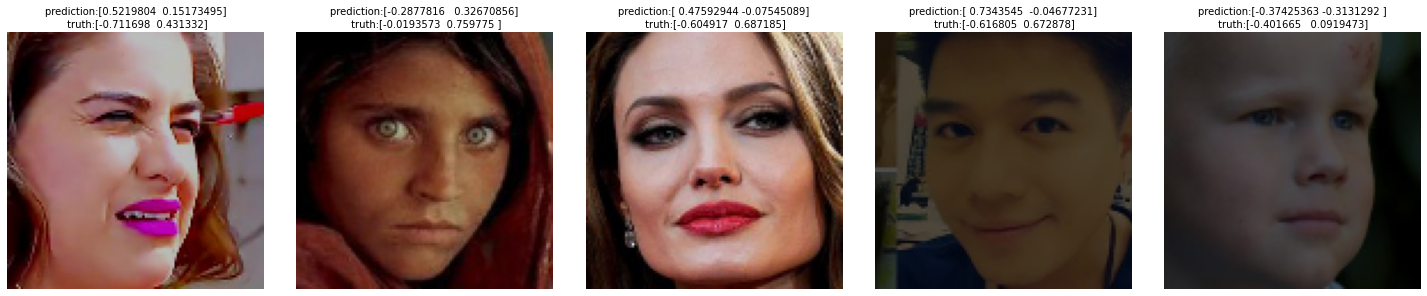

In [ ]:
show_predictions(5)

# After Split

In [ ]:
df_info = pd.concat([df_train,df_val])

In [ ]:
def train_val_test_split(category):
  len_list = len(category)
  train_per = int(len_list*0.55)
  val_per = int(len_list*0.15)
  test_per = int(len_list*0.30)
  
  train_category = list(category['face_name_align'][:train_per])
  val_category = list(category['face_name_align'][train_per:train_per+val_per])
  test_category = list(category['face_name_align'][train_per+val_per:])

  return train_category,val_category,test_category



In [ ]:
RACES =['White','Black','Asian','Indian']
AGES = ['0-2','3-9','10-19','20-29','30-39','40-49','50-59','60-69','70+']
GENDERS = ['Male','Female']



In [ ]:
# gender-race-age split
train_new = []
validation_new = []
test_new= []

for gender in GENDERS:
  for race in RACES:
    for age in AGES:
      for v in np.arange(-1,1.2,0.2):
        for a in np.arange(-1,1.2,0.2):
          v = np.round(v,2)
          a = np.round(a,2)
          print("gender:",gender,"race:",race,"age:",age,'valence: ',np.round(v,2),'arousal: ',np.round(a,2))
          df_category = df_info[(df_info['valence']>=v) & (df_info['valence']<v+0.2) & (df_info['arousal']>=a) & (df_info['arousal']<a+0.2) & (df_info['gender']==gender) & (df_info['race']==race) & (df_info['age']==age)] 
          train_c,val_c,test_c = train_val_test_split(df_category)
          train_new.append(train_c)
          validation_new.append(val_c)
          test_new.append(test_c)   
       
    

In [ ]:
train_list = list(np.concatenate(train_new).flat)
validation_list = list(np.concatenate(validation_new).flat)
test_list= list(np.concatenate(test_new).flat)


In [ ]:
len(train_list)+len(validation_list)+len(test_list)

In [ ]:
df_train_fair = df_info[df_info['face_name_align'].isin(train_list)]
df_validation_fair = df_info[df_info['face_name_align'].isin(validation_list)]
df_test_fair = df_info[df_info['face_name_align'].isin(test_list)]

In [ ]:
#joblib.dump(df_train_fair,'/content/gdrive/MyDrive/train_net/AffectNet_VA/df_train_fair')
#joblib.dump(df_test_fair,'/content/gdrive/MyDrive/train_net/AffectNet_VA/df_test_fair')
#joblib.dump(df_validation_fair,'/content/gdrive/MyDrive/train_net/AffectNet_VA/df_validation_fair')

df_train_fair = joblib.load('/content/gdrive/MyDrive/train_net/AffectNet_VA/df_train_fair')
df_test_fair = joblib.load('/content/gdrive/MyDrive/train_net/AffectNet_VA/df_test_fair')
df_validation_fair = joblib.load('/content/gdrive/MyDrive/train_net/AffectNet_VA/df_validation_fair')


##Show data

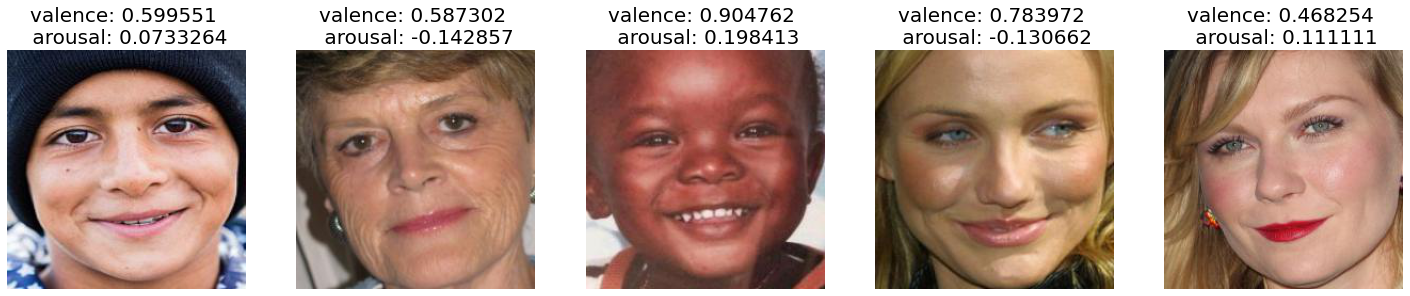

In [ ]:
num_images = 5
fig, axs = plt.subplots(figsize=(20, 4), ncols=num_images, constrained_layout=True)
for i in range(num_images):
  image  =  mpimg.imread(df_train_fair['face_name_align'][300+i])
  axs[i].imshow(image)  
  axs[i].set_title('valence: {} \n arousal: {}'.format(df_train_fair['valence'][300+i],df_train_fair['arousal'][300+i]),fontsize = 20)
  axs[i].axis("off")



## data preprocessing 

In [ ]:
# load one image
image = Image.open(df_train_fair['face_name_align'][30])
# convert image to numpy array
data = np.asarray(image)

In [ ]:
print(np.shape(data))

(224, 224, 3)


Οι εικόνες που στέλνουμε στο νευρωνικό δίκτυο είναι resized σε 224*224και είναι έγχρωμες (τιμές απο 0-255). <br>

  Έτσι στο δίκτυο οι πίνακες είναι μεγέθους 224 * 224 * 3. <br>Μειώνω τις διαστάσεις των εικόνων σε 112 * 112 * 3 

In [ ]:
# get batches of tensor image data (rescaled to 0-1)
train_datagen = ImageDataGenerator(rescale=1./255,horizontal_flip=True,brightness_range=[0.2,1.0])
test_datagen = ImageDataGenerator(rescale=1./255,horizontal_flip=True,brightness_range=[0.2,1.0])

In [ ]:
batch_size = 128
#load and iterate training dataset
train_generator = train_datagen.flow_from_dataframe(
    df_train_fair,
    x_col='face_name_align',
    y_col=['valence','arousal'], #multitask
    target_size=(112, 112), 
    color_mode='rgb',
    class_mode='raw', #regression
    batch_size=batch_size
)
# load and iterate validation dataset
validation_generator = test_datagen.flow_from_dataframe(
    df_validation_fair,
    x_col='face_name_align',
    y_col=['valence','arousal'],
    target_size=(112, 112), 
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size
)

# load and iterate validation dataset
test_generator = test_datagen.flow_from_dataframe(
    df_test_fair,
    x_col='face_name_align',
    y_col=['valence','arousal'],
    target_size=(112, 112), 
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size,
    shuffle = False
)

Found 157650 validated image filenames.
Found 41633 validated image filenames.
Found 91297 validated image filenames.


In [ ]:
df_info

,face_name_align,valence,arousal,race,gender,age
0,/content/train_set/images/102819.jpg,-0.404762,0.476190,Indian,Male,30-39
1,/content/train_set/images/364716.jpg,0.754936,0.101626,White,Female,10-19
2,/content/train_set/images/50848.jpg,0.714286,-0.174603,White,Female,20-29
3,/content/train_set/images/228471.jpg,-0.425861,0.445219,Asian,Male,20-29
4,/content/train_set/images/324085.jpg,-0.029036,0.701703,White,Female,20-29
...,...,...,...,...,...,...
3981,/content/val_set/images/374.jpg,-0.634921,0.626984,White,Female,20-29
3982,/content/val_set/images/364.jpg,-0.056073,0.901484,Black,Male,0-2
3983,/content/val_set/images/373.jpg,-0.721660,0.505689,White,Female,30-39
3984,/content/val_set/images/371.jpg,-0.591463,0.619148,White,Female,20-29


## data distribution

In [ ]:
def show_v_a_distribution(df_train,df_val,df_test):
 
  sets = ['train','validation','test']
  fig,axs = plt.subplots(figsize =(18, 5),ncols=3)
  for i,df in enumerate([df_train,df_val,df_test]):
    x = df['arousal']
    y = df['valence']
    hist = axs[i].hist2d(x, y,range =  [[-1, 1], [-1, 1]])
    axs[i].set_xlabel('arousal', fontsize=12)
    axs[i].set_ylabel('valence', fontsize=12)
    axs[i].set_title("Distribution of {} set".format(sets[i]), fontsize=15)
    fig.colorbar(hist[3], ax=axs[i])


In [ ]:
def plot_samples(category,names,train_counter,val_counter,test_counter):
  fig, axs = plt.subplots(figsize=(20, 4), ncols=3, constrained_layout=True)
  sets = ['train','validation','test']
  for i,set_counter in enumerate([train_counter,val_counter,test_counter]):
    names_list = [name for name in names]
    axs[i].bar(names_list,set_counter,color='c',  edgecolor='black')
    axs[i].set_title("{} distribution for {} set".format(category,sets[i]),fontsize=15)

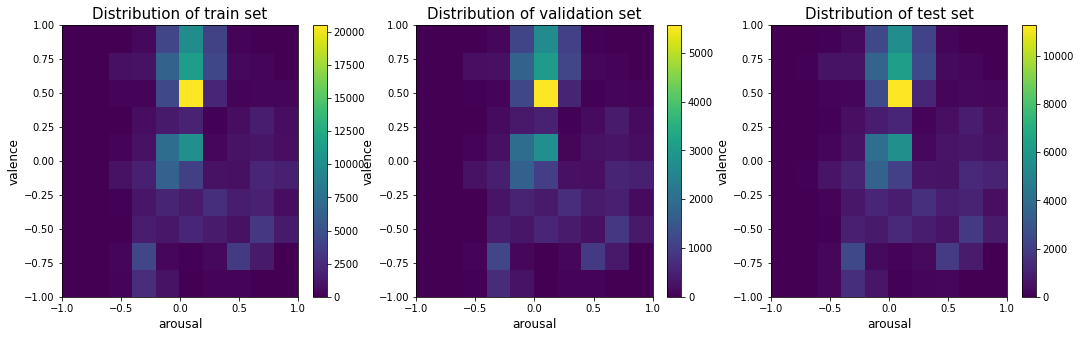

In [ ]:
show_v_a_distribution(df_train_fair,df_validation_fair,df_test_fair)

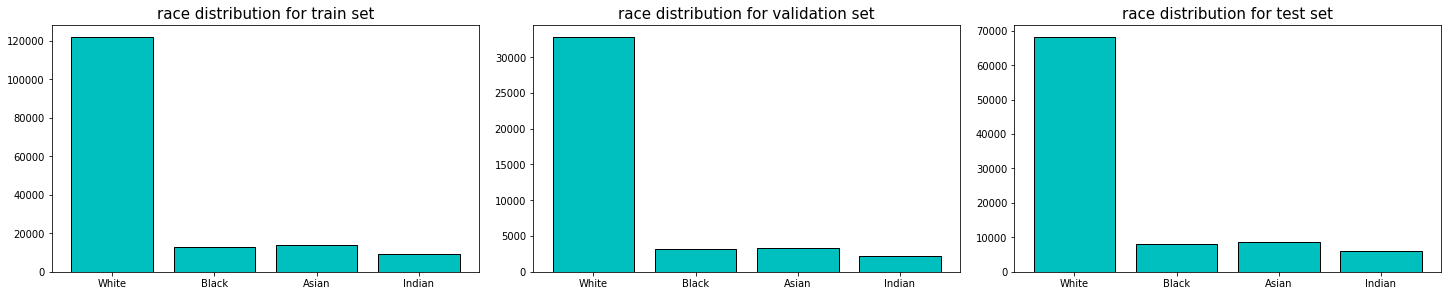

In [ ]:
race_names = ['White','Black','Asian','Indian']

race_counter_train = []
for i in range(len(race_names)):
  race_counter_train.append(len(df_train_fair[df_train_fair['race']==race_names[i]]))

race_counter_val = []
for i in range(len(race_names)):
  race_counter_val.append(len(df_validation_fair[df_validation_fair['race']==race_names[i]]))

race_counter_test = []
for i in range(len(race_names)):
  race_counter_test.append(len(df_test_fair[df_test_fair['race']==race_names[i]]))

plot_samples('race',race_names,race_counter_train,race_counter_val,race_counter_test)


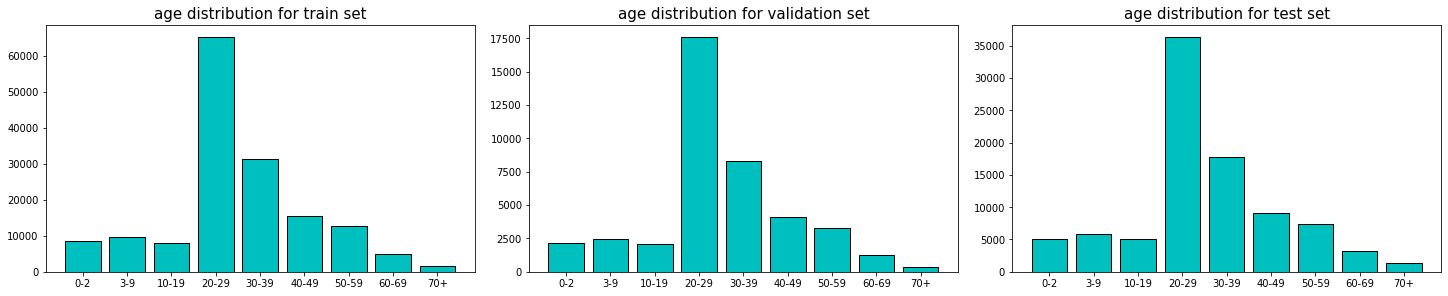

In [ ]:
age_names = ['0-2','3-9','10-19','20-29','30-39','40-49','50-59','60-69','70+']

age_counter_train = []
for i in range(len(age_names)):
  age_counter_train.append(len(df_train_fair[df_train_fair['age']==age_names[i]]))

age_counter_val = []
for i in range(len(age_names)):
  age_counter_val.append(len(df_validation_fair[df_validation_fair['age']==age_names[i]]))

age_counter_test = []
for i in range(len(age_names)):
  age_counter_test.append(len(df_test_fair[df_test_fair['age']==age_names[i]]))

plot_samples('age',age_names,age_counter_train,age_counter_val,age_counter_test)


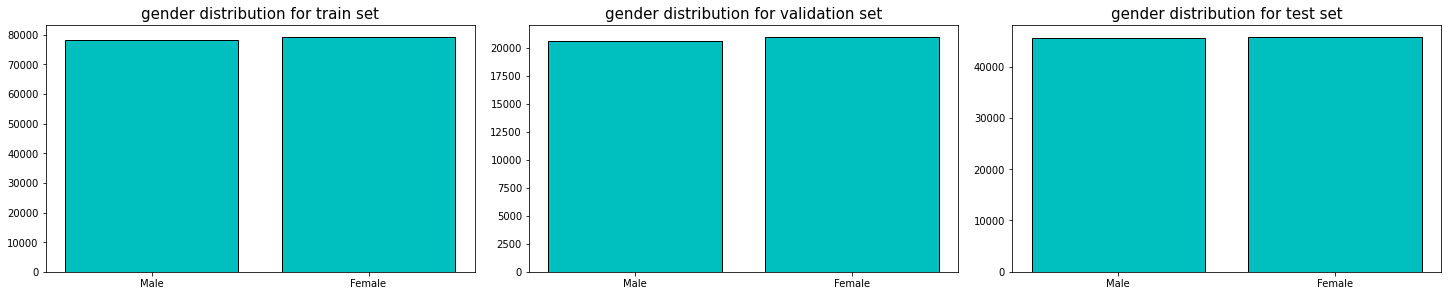

In [ ]:
gender_names = ['Male','Female']

gender_counter_train = []
for i in range(len(gender_names)):
  gender_counter_train.append(len(df_train_fair[df_train_fair['gender']==gender_names[i]]))

gender_counter_val = []
gender_names =  ['Male','Female']
for i in range(len(gender_names)):
  gender_counter_val.append(len(df_validation_fair[df_validation_fair['gender']==gender_names[i]]))

gender_counter_test = []
gender_names =  ['Male','Female']
for i in range(len(gender_names)):
  gender_counter_test.append(len(df_test_fair[df_test_fair['gender']==gender_names[i]]))

plot_samples('gender',gender_names,gender_counter_train,gender_counter_val,gender_counter_test)


## training

In [ ]:
#pretrained model 
base_model =  tf.keras.applications.ResNet50(
    include_top=False, #custume input and output layers based on our data
    weights="imagenet", #use weights from imagenet training 
    input_shape=(112,112,3),
    pooling='avg',
)

#use functional API to allow multiple outputs
# input shape
inputs = tf.keras.Input(shape=(112, 112, 3))
# model architecture
x = base_model(inputs, training=True)
x = Dense(512, activation="relu")(x)
#x = Dropout(0.2)(x)
#x = Dense(512,activation= "relu")(x)
#output --> 2 tasks: valence & arousal
outputs = tf.keras.layers.Dense(2,activation="linear")(x) #change to tanh and see results
model = tf.keras.Model(inputs, outputs)
  

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 24,637,826
Trainable params: 24,584,706
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
#compile model
model.compile(optimizer=Adam(learning_rate=0.001),
                     loss= concordance_cc2_loss) #mean absolute error, Pearsons Correlation Coefficient

In [ ]:
#checkpoint 
filepath = "/content/gdrive/MyDrive/train_net/ckp_models/AffectNetVA/AffectNetVA_aug/AffectNetVA_after_128/AffectNet-{epoch:02d}.h5"
checkpoint = ModelCheckpoint(  
    filepath,
    monitor="val_loss",
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch")

callbacks_list = [checkpoint]


#fit model
history = model.fit(train_generator,validation_data=validation_generator,epochs=10,callbacks=callbacks_list)


Epoch 1/10
1232/1232 [==============================] - ETA: 0s - loss: 0.3955
Epoch 1: saving model to /content/gdrive/MyDrive/train_net/ckp_models/AffectNetVA/AffectNetVA_aug/AffectNetVA_after_128/AffectNet-01.h5
1232/1232 [==============================] - 565s 454ms/step - loss: 0.3955 - val_loss: 0.3375
Epoch 2/10
1232/1232 [==============================] - ETA: 0s - loss: 0.3270
Epoch 2: saving model to /content/gdrive/MyDrive/train_net/ckp_models/AffectNetVA/AffectNetVA_aug/AffectNetVA_after_128/AffectNet-02.h5
1232/1232 [==============================] - 543s 440ms/step - loss: 0.3270 - val_loss: 0.3238
Epoch 3/10
1232/1232 [==============================] - ETA: 0s - loss: 0.3092
Epoch 3: saving model to /content/gdrive/MyDrive/train_net/ckp_models/AffectNetVA/AffectNetVA_aug/AffectNetVA_after_128/AffectNet-03.h5
1232/1232 [==============================] - 542s 440ms/step - loss: 0.3092 - val_loss: 0.3142
Epoch 4/10
1232/1232 [==============================] - ETA: 0s - loss

## evaluation


In [ ]:
models_labels_fair = {}
models_predictions_fair = {}
models_directory = '/content/gdrive/MyDrive/train_net/ckp_models/AffectNetVA/AffectNetVA_aug/AffectNetVA_after_128'
for saved_model in (os.listdir(models_directory)):
  model = tf.keras.models.load_model(os.path.join(models_directory,saved_model),custom_objects={'concordance_cc2_loss':concordance_cc2_loss})
  models_labels_fair[saved_model[:-3]] = test_generator.labels
  models_predictions_fair[saved_model[:-3]] = model.predict(test_generator)


In [ ]:
for model_name in models_labels_fair.keys():
  
  valence_labels= []
  valence_predictions = []
  arousal_labels = []
  arousal_predictions = []

  labels,predictions = models_labels_fair[model_name],models_predictions_fair[model_name]
  for (v_l,a_l),(v_p,a_p) in zip(labels,predictions):
    valence_labels.append(v_l)
    valence_predictions.append(v_p)
    arousal_labels.append(a_l)
    arousal_predictions.append(a_p)

  print("Model Name: =",model_name)
  correlation_v,mse_v,mae_v = correlation_mse_mae(valence_labels,valence_predictions)
  correlation_a,mse_a,mae_a = correlation_mse_mae(arousal_labels,arousal_predictions)
  data = [["Pearsons Correlation",correlation_v,correlation_a],["Mean Squared Error",mse_v,mse_a],["Mean Absolute Error",mae_v,mae_a]]
  print(tabulate(data, headers=[" Valence","Arousal"]))
  print('\n\n')

Model Name: = AffectNet-01
                         Valence    Arousal
--------------------  ----------  ---------
Pearsons Correlation    0.764892  0.52898
Mean Squared Error      0.124296  0.0826881
Mean Absolute Error     0.260722  0.20262



Model Name: = AffectNet-02
                         Valence    Arousal
--------------------  ----------  ---------
Pearsons Correlation    0.775758  0.541817
Mean Squared Error      0.111046  0.0799103
Mean Absolute Error     0.245653  0.198668



Model Name: = AffectNet-03
                         Valence    Arousal
--------------------  ----------  ---------
Pearsons Correlation    0.786951  0.551754
Mean Squared Error      0.110397  0.0833203
Mean Absolute Error     0.24632   0.202499



Model Name: = AffectNet-04
                         Valence    Arousal
--------------------  ----------  ---------
Pearsons Correlation    0.791824  0.572375
Mean Squared Error      0.118055  0.0828113
Mean Absolute Error     0.254775  0.203784



Model Name

In [ ]:
best_model_name = 'AffectNet-09'
best_model = tf.keras.models.load_model(os.path.join(models_directory,"{}.h5".format(best_model_name)),custom_objects={'concordance_cc2_loss':concordance_cc2_loss})


In [ ]:
y_true_race,y_pred_race,counter_race = predictions_labels_category(test_generator,df_test_fair,
                                                      models_labels_fair[best_model_name],models_predictions_fair[best_model_name],
                                                      RACES,'race')

y_true_age,y_pred_age,counter_age = predictions_labels_category(test_generator,df_test_fair,
                                                    models_labels_fair[best_model_name],models_predictions_fair[best_model_name],
                                                    AGES,'age')

y_true_gender,y_pred_gender,counter_gender = predictions_labels_category(test_generator,df_test_fair,
                                                          models_labels_fair[best_model_name],models_predictions_fair[best_model_name],
                                                          GENDERS,'gender')


In [ ]:
print("OVERALL scores after split")
labels,predictions = models_labels_fair[best_model_name],models_predictions_fair[best_model_name]
v_l,v_p,a_l,a_p = valence_arousal(labels,predictions)
data = [["Pearsons Correlation",correlation_mse_mae(v_l,v_p)[0],correlation_mse_mae(a_l,a_p)[0]],
        ["Mean Absolute Error",correlation_mse_mae(v_l,v_p)[2],correlation_mse_mae(a_l,a_p)[2]]]
print(tabulate(data, headers=[" Valence","Arousal"]))
print()
results_category('after',RACES,'race',y_true_race,y_pred_race,counter_race)
results_category('after',AGES,'age',y_true_age,y_pred_age,counter_age)
results_category('after',GENDERS,'gender',y_true_gender,y_pred_gender,counter_gender)


OVERALL scores after split
                         Valence    Arousal
--------------------  ----------  ---------
Pearsons Correlation    0.801882   0.585377
Mean Absolute Error     0.243856   0.190726

race scores after split
race      #images    Correlation    Correlation    Mean Absolute Error    Mean Absolute Error
                         Valence        Arousal                Valence                Arousal
------  ---------  -------------  -------------  ---------------------  ---------------------
White       68301       0.800544       0.592805               0.243067               0.188744
Black        8098       0.813621       0.572785               0.243884               0.194755
Asian        8793       0.802853       0.544855               0.245096               0.19667
Indian       6105       0.792659       0.565704               0.250861               0.198994

age scores after split
age      #images    Correlation    Correlation    Mean Absolute Error    Mean Absolute Erro

In [ ]:
print("AffectNet: valence & arousal task")
print("loss: concordance loss")
print("data augmentation: YES")
print("AFTER split")
labels,predictions = models_labels_fair[best_model_name],models_predictions_fair[best_model_name]
v_l,v_p,a_l,a_p = valence_arousal(labels,predictions)
data = [["Pearsons Correlation",correlation_mse_mae(v_l,v_p)[0],correlation_mse_mae(a_l,a_p)[0]]]
        
print(tabulate(data, headers=[" Valence","Arousal"]))
print()
results_category_nomse('after',RACES,'race',y_true_race,y_pred_race,counter_race)
results_category_nomse('after',AGES,'age',y_true_age,y_pred_age,counter_age)
results_category_nomse('after',GENDERS,'gender',y_true_gender,y_pred_gender,counter_gender)


AffectNet: valence & arousal task
loss: concordance loss
data augmentation: YES
AFTER split
                         Valence    Arousal
--------------------  ----------  ---------
Pearsons Correlation    0.801882   0.585377

race scores after split
race      #images    Correlation    Correlation
                         Valence        Arousal
------  ---------  -------------  -------------
White       68301       0.800544       0.592805
Black        8098       0.813621       0.572785
Asian        8793       0.802853       0.544855
Indian       6105       0.792659       0.565704

age scores after split
age      #images    Correlation    Correlation
                        Valence        Arousal
-----  ---------  -------------  -------------
0-2         5116       0.849552       0.628662
3-9         5905       0.850237       0.653594
10-19       5049       0.798031       0.532696
20-29      36404       0.789195       0.576955
30-39      17732       0.806274       0.595916
40-49       909